In [133]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import word_tokenize, wordpunct_tokenize, WhitespaceTokenizer, \
                          RegexpTokenizer, sent_tokenize, MWETokenizer
from nltk.util import ngrams
from nltk.chunk import ne_chunk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import gensim

import warnings
import logging
import pickle

%matplotlib inline
pd.options.display.max_columns = 100

In [149]:
# this code doesn't work anymore after upgrading to pandas 0.20.1,
# will get ModuleNotFoundError: No module named 'pandas.indexes'
# with open("cleaned_data.pkl", 'rb') as picklefile: 
#     book_review = pickle.load(picklefile)
book_review = pd.read_pickle("cleaned_data.pkl")

In [158]:
bk_title_df = book_review[['bookid', 'bk_title']].drop_duplicates()
bk_title_df.set_index('bookid', inplace = True)

In [3]:
cond = book_review['bk_desc_len'] == 0
book_coll = book_review.loc[~cond, ['bookid', 'bk_desc']].drop_duplicates()
book_coll.set_index('bookid', inplace = True)

bookid_order = book_coll.index
book_coll.tail(1)

,bk_desc
bookid,
17261174,"A little bit Tintin, a little bit Indiana Jone..."


### preprocessing

In [4]:
book_coll['tokens'] = book_coll["bk_desc"].map(lambda x: word_tokenize(x))
book_coll.tail(1)

,bk_desc,tokens
bookid,,
17261174,"A little bit Tintin, a little bit Indiana Jone...","[A, little, bit, Tintin, ,, a, little, bit, In..."


In [5]:
stemmer = LancasterStemmer()
book_coll['stemmed'] = book_coll["tokens"].map(lambda x: " ".join([stemmer.stem(y) for y in x]))
book_coll.tail(1)

,bk_desc,tokens,stemmed
bookid,,,
17261174,"A little bit Tintin, a little bit Indiana Jone...","[A, little, bit, Tintin, ,, a, little, bit, In...","a littl bit tintin , a littl bit indian jon , ..."


### sentiment

In [6]:
sid = SentimentIntensityAnalyzer()

In [7]:
sid_df = book_coll.copy()
sid_df['dict'] = sid_df["stemmed"].map(sid.polarity_scores)
sid_df = pd.concat([sid_df.drop(['dict'], axis=1), sid_df['dict'].apply(pd.Series)], axis=1)
sid_df.tail(1)

,bk_desc,tokens,stemmed,compound,neg,neu,pos
bookid,,,,,,,
17261174,"A little bit Tintin, a little bit Indiana Jone...","[A, little, bit, Tintin, ,, a, little, bit, In...","a littl bit tintin , a littl bit indian jon , ...",-0.4404,0.185,0.726,0.089


In [8]:
sid_df = sid_df.drop(['bk_desc', 'tokens', 'stemmed'], axis = 1)
# sid_df.reset_index(inplace = True)
sid_df.tail(1)

,compound,neg,neu,pos
bookid,,,,
17261174,-0.4404,0.185,0.726,0.089


### more preprocessing

In [9]:
cv = TfidfVectorizer(strip_accents = 'unicode' 
                     , ngram_range = (1, 2)
                     , stop_words = "english"
                     , max_df = 0.5
                     , min_df = 5
                     , norm = 'l2' # important to normalize?
                     )
book_coll = cv.fit_transform(book_coll['stemmed'])
book_coll = pd.DataFrame(book_coll.todense(), columns=[cv.get_feature_names()], index=sid_df.index)
book_coll.tail(1)

,10,18,1945,20th,20th century,abandon,abduc,abl,aboard,abound,abov,abov al,abraham,abraham lincoln,absolv,academy,acc,acceiv,accid,acclaim,accompany,accompl,account,accus,achiev,acquaint,act,ad,adam,addict,addit,adopt,adult,adv,adv set,adv wil,adventure,advers,affair,affect,afoot,afr,afric,aft,aft al,ag,ago,agr,ahead,aid,...,wint,wip,wis,wish,wit,witch,wizard,wo,wolf,wolfgard,wom,won,wond,wood,wor,word,work,work togeth,world,world ar,world ev,world forev,world know,world war,world wher,world wil,worry,wors,worst,wound,wov,writ,wrong,ya,ye,year,year aft,year ago,year lat,year old,year sint,yo,york,york city,york tim,young,young lady,young man,young wom,zomby
bookid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17261174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.178602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### merge with sentiment

In [10]:
sid_df.columns = "sentiment_" + np.array(sid_df.columns)
book_coll = book_coll.merge(sid_df, left_index=True, right_index=True)
book_coll.tail(1)

,10,18,1945,20th,20th century,abandon,abduc,abl,aboard,abound,abov,abov al,abraham,abraham lincoln,absolv,academy,acc,acceiv,accid,acclaim,accompany,accompl,account,accus,achiev,acquaint,act,ad,adam,addict,addit,adopt,adult,adv,adv set,adv wil,adventure,advers,affair,affect,afoot,afr,afric,aft,aft al,ag,ago,agr,ahead,aid,...,wit,witch,wizard,wo,wolf,wolfgard,wom,won,wond,wood,wor,word,work,work togeth,world,world ar,world ev,world forev,world know,world war,world wher,world wil,worry,wors,worst,wound,wov,writ,wrong,ya,ye,year,year aft,year ago,year lat,year old,year sint,yo,york,york city,york tim,young,young lady,young man,young wom,zomby,sentiment_compound,sentiment_neg,sentiment_neu,sentiment_pos
bookid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17261174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.178602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.4404,0.185,0.726,0.089


In [11]:
cols = book_coll.columns
rows = book_coll.index
# book_coll = pd.DataFrame(MinMaxScaler().fit_transform(book_coll), columns = cols, index = rows)
book_coll = pd.DataFrame(normalize(book_coll, axis = 0, norm = "l2"), columns = cols, index = rows)
book_coll.tail(1)

,10,18,1945,20th,20th century,abandon,abduc,abl,aboard,abound,abov,abov al,abraham,abraham lincoln,absolv,academy,acc,acceiv,accid,acclaim,accompany,accompl,account,accus,achiev,acquaint,act,ad,adam,addict,addit,adopt,adult,adv,adv set,adv wil,adventure,advers,affair,affect,afoot,afr,afric,aft,aft al,ag,ago,agr,ahead,aid,...,wit,witch,wizard,wo,wolf,wolfgard,wom,won,wond,wood,wor,word,work,work togeth,world,world ar,world ev,world forev,world know,world war,world wher,world wil,worry,wors,worst,wound,wov,writ,wrong,ya,ye,year,year aft,year ago,year lat,year old,year sint,yo,york,york city,york tim,young,young lady,young man,young wom,zomby,sentiment_compound,sentiment_neg,sentiment_neu,sentiment_pos
bookid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17261174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.164848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.022749,0.071408,0.029707,0.043199


### get latent features

In [12]:
init_n_components = min(book_coll.shape) - 1
init_n_components = 100

In [13]:
tSVD_model = TruncatedSVD(n_components = init_n_components)
tSVD_model.fit(book_coll)

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
       random_state=None, tol=0.0)

In [14]:
var_ratio_df = pd.DataFrame(tSVD_model.explained_variance_ratio_)
var_ratio_df.columns = ['var_ratio']
var_ratio_df['cum_var_ratio'] = var_ratio_df['var_ratio'].cumsum()
var_ratio_df.head(1)

,var_ratio,cum_var_ratio
0,0.002253,0.002253


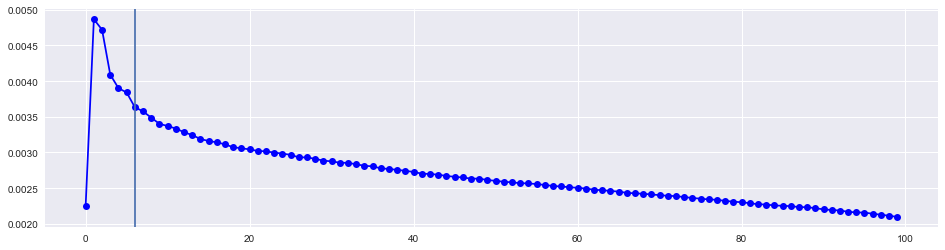

In [15]:
plt.figure(figsize = (16, 4))
plt.plot(var_ratio_df['var_ratio'], 'b-o')
plt.axvline(6)
plt.show()

In [16]:
# plt.figure(figsize = (16, 4))
# plt.plot(var_ratio_df['cum_var_ratio'], 'r-')
# plt.axvline(25)
# plt.axhline(0.8)
# plt.show()

In [17]:
elbow_n_components = 7 # TODO Or 8? Tune this?

In [18]:
U, Sigma, VT = randomized_svd(book_coll, 
                              n_components=elbow_n_components,
                              n_iter=5,
                              random_state=None)
print(book_coll.shape, U.shape, Sigma.shape, VT.shape)

(788, 2258) (788, 7) (7,) (7, 2258)


In [19]:
# reconstruc_recomm_by_stars = pd.DataFrame(np.dot(U, np.dot(np.diag(Sigma), VT)))
# reconstruc_recomm_by_stars.index = recomm_by_stars.index
# reconstruc_recomm_by_stars.columns = recomm_by_stars.columns
# print(reconstruc_recomm_by_stars.shape)
# reconstruc_recomm_by_stars.iloc[:5, :5]

In [20]:
book_latent = pd.DataFrame(U)
book_latent.index = book_coll.index
book_latent.columns = pd.Series(book_latent.columns).map(lambda x: 'bk_latent' + str(x))
# book_latent['bookid'] = bookid_order
book_latent.tail(1)

,bk_latent0,bk_latent1,bk_latent2,bk_latent3,bk_latent4,bk_latent5,bk_latent6
bookid,,,,,,,
17261174,0.013838,-0.003421,-0.003525,-0.017953,0.00256,-0.010162,-0.018068


In [21]:
book_latent['PCA_grouping'] = book_latent.idxmax(axis = 1)
book_latent.tail(5)

,bk_latent0,bk_latent1,bk_latent2,bk_latent3,bk_latent4,bk_latent5,bk_latent6,PCA_grouping
bookid,,,,,,,,
9593,0.029675,-0.030812,0.016775,-0.003514,0.012251,-0.000062,-0.032105,bk_latent0
769483,0.024035,-0.032677,0.008587,-0.026938,-0.036917,-0.018018,-0.033049,bk_latent0
703,0.018575,0.021060,-0.005876,-0.006640,0.021602,0.001111,0.008305,bk_latent4
12820793,0.037174,0.012114,-0.019941,0.033860,-0.000934,0.031146,0.021762,bk_latent0
17261174,0.013838,-0.003421,-0.003525,-0.017953,0.002560,-0.010162,-0.018068,bk_latent0


### Kmeans

In [62]:
kclust = KMeans(n_clusters = elbow_n_components, random_state = 2320)

In [63]:
book_kclust = pd.DataFrame(kclust.fit_predict(book_coll))
book_kclust.columns = ['kmeans_grouping']
book_kclust.set_index(rows, inplace = True)
book_kclust.tail(1)

,kmeans_grouping
bookid,
17261174,5


### DBscan

In [130]:
dbscan = DBSCAN(eps=0.6, min_samples=3, metric='cosine', algorithm='brute') # TODO tune this

In [131]:
book_dbscan = pd.DataFrame(dbscan.fit_predict(book_coll))
book_dbscan.columns = ['dbscan_grouping']
book_dbscan.set_index(rows, inplace = True)
book_dbscan.tail(1)

,dbscan_grouping
bookid,
17261174,-1


In [132]:
book_dbscan['dbscan_grouping'].value_counts()

-1    780
 1      5
 0      3
Name: dbscan_grouping, dtype: int64

### hierarchical

In [135]:
tree = AgglomerativeClustering(n_clusters = elbow_n_components)

In [137]:
book_treeclust = pd.DataFrame(tree.fit_predict(book_coll))
book_treeclust.columns = ['treeclust_grouping']
book_treeclust.set_index(rows, inplace = True)
book_treeclust.tail(1)

,treeclust_grouping
bookid,
17261174,0


In [138]:
book_treeclust['treeclust_grouping'].value_counts()

0    752
2     14
6      6
1      6
3      5
5      3
4      2
Name: treeclust_grouping, dtype: int64

In [141]:
# trying to plot dendrogram
# from scipy.cluster.hierarchy import dendrogram, linkage
# data = [[0., 0.], [0.1, -0.1], [1., 1.], [1.1, 1.1]]
# Z = linkage(data)
# dendrogram(Z)  

### compare groupings

In [159]:
book_grps = book_latent.merge(book_kclust, left_index = True, right_index = True)
book_grps = book_grps.merge(book_treeclust, left_index = True, right_index = True)
book_grps = book_grps.merge(bk_title_df, left_index = True, right_index = True)
compare_mx
book_grps.tail(1)

,bk_latent0,bk_latent1,bk_latent2,bk_latent3,bk_latent4,bk_latent5,bk_latent6,PCA_grouping,kmeans_grouping,treeclust_grouping,bk_title
bookid,,,,,,,,,,,
17261174,0.013838,-0.003421,-0.003525,-0.017953,0.00256,-0.010162,-0.018068,bk_latent0,5,0,Delilah Dirk and the Turkish Lieutenant


In [155]:
compare_mx = pd.crosstab(book_grps['PCA_grouping'], book_grps['kmeans_grouping'])
compare_mx

kmeans_grouping,0,1,2,3,4,5,6
PCA_grouping,,,,,,,
bk_latent0,260,1043,3,0,119,6888,636
bk_latent1,45,159,106,0,0,304,34
bk_latent2,240,0,46,0,22,1170,0
bk_latent3,0,225,0,0,122,778,4
bk_latent4,4,38,0,0,10,1221,150
bk_latent5,109,425,0,0,0,746,0
bk_latent6,281,530,150,88,50,854,107


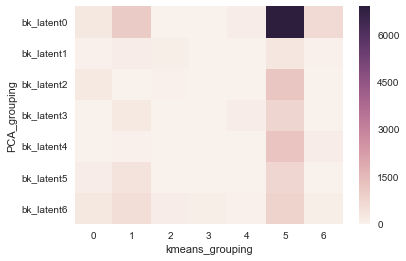

In [156]:
sns.heatmap(compare_mx)

In [147]:
compare_mx = pd.crosstab(book_grps['PCA_grouping'], book_grps['treeclust_grouping'])
compare_mx

treeclust_grouping,0,1,2,3,4,5,6
PCA_grouping,,,,,,,
bk_latent0,443,0,0,0,0,0,0
bk_latent1,23,0,0,0,0,0,0
bk_latent2,46,0,0,5,1,0,0
bk_latent3,53,0,12,0,0,0,0
bk_latent4,75,0,2,0,1,0,0
bk_latent5,51,6,0,0,0,3,0
bk_latent6,61,0,0,0,0,0,6


In [148]:
compare_mx = pd.crosstab(book_grps['kmeans_grouping'], book_grps['treeclust_grouping'])
compare_mx

treeclust_grouping,0,1,2,3,4,5,6
kmeans_grouping,,,,,,,
0,42,1,0,0,2,1,2
1,99,0,3,0,0,1,0
2,9,0,0,0,0,0,0
3,0,0,0,0,0,0,3
4,14,0,0,0,0,0,0
5,542,5,10,5,0,1,1
6,46,0,1,0,0,0,0


In [160]:
cond = book_grps['treeclust_grouping'] != 0
book_grps[cond]

,bk_latent0,bk_latent1,bk_latent2,bk_latent3,bk_latent4,bk_latent5,bk_latent6,PCA_grouping,kmeans_grouping,treeclust_grouping,bk_title
bookid,,,,,,,,,,,
6390031,0.038976,-0.217357,0.205870,-0.101931,0.192750,0.076115,0.196156,bk_latent2,0,4,The Improbable Adventures of Sherlock Holmes
25143224,0.047369,0.016395,-0.023453,0.078107,0.098364,-0.032397,-0.025059,bk_latent4,5,2,The British Lion
26042254,0.045748,-0.000056,-0.002020,0.055701,0.001589,-0.017068,-0.009335,bk_latent3,5,2,The Last Days of New Paris
10989,0.042243,-0.064154,0.071860,-0.046191,-0.094483,0.161336,-0.146674,bk_latent5,5,1,The Outlandish Companion
30037861,0.042927,-0.014178,-0.005284,0.118885,0.056317,0.023109,-0.013012,bk_latent3,1,2,Silver Stars
104078,0.038109,-0.046953,0.015482,0.043328,-0.083567,-0.025217,-0.013344,bk_latent3,5,2,Ysabel
17563080,0.043846,0.282130,0.316958,0.053545,-0.048037,-0.037507,-0.017047,bk_latent2,5,3,Murder of Crows
134261,0.051170,-0.027323,0.022917,0.128012,0.094571,0.038173,-0.007529,bk_latent3,1,2,1945
21457243,0.039584,0.294443,0.309989,0.108156,-0.024946,-0.044403,-0.031161,bk_latent2,5,3,Vision in Silver
